# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


print("Complete")

Complete


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [24]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = max(y_train) +1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape is", image_shape)
print("Number of classes =", n_classes)
print("Complete")

Number of training examples = 62494
Number of testing examples = 12630
Image data shape is (32, 32, 3)
Number of classes = 43
Complete


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

14
Complete


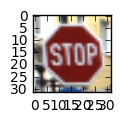

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(1, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])
print("Complete")


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

print("Complete")

Complete


In [5]:
### Generate data additional data
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
"""

"""

inputs_per_class = np.bincount(y_train)
max_inputs = np.max(inputs_per_class)

print(inputs_per_class)
print(max_inputs)

import scipy.ndimage

print('Preprocessing data...')
# Generate additional data for underrepresented classes
print('Generating additional data...')

angles = [-5, 5, -10, 10, -15, 15, -20, 20]
#scale = [.9, 1.1]
#pixel_shift = [-2, 2, -1, 1, -3, 3, -4, 4]


print(len(angles))
print(len(pixel_shift))

for label in range(len(inputs_per_class)):
    input_ratio = min(int(max_inputs / inputs_per_class[label]) - 1, len(angles) - 1)

    print(input_ratio)
    
    if input_ratio <= 1:
        continue

    new_features = []
    new_labels = []
    mask = np.where(y_train == label)

    for j in range(input_ratio):
        for feature in X_train[mask]:
            
            # Rotate 
            new_features.append(scipy.ndimage.interpolation.rotate(feature, angles[j], reshape=False))
            new_labels.append(label)
            
            # Scale
            #new_features.append(scipy.ndimage.interpolation.zoom(feature, scale[j]))
            #new_labels.append(label)
            
            # Pixel_shift
            #new_features.append(scipy.ndimage.interpolation.shift(feature, pixel_shift[j]))
            #new_labels.append(label)

    X_train = np.append(X_train, new_features, axis=0)
    y_train = np.append(y_train, new_labels, axis=0)

# Normalize features
print('Normalizing features...')
X_train = X_train / 255. * 0.8 + 0.1

inputs_per_class = np.bincount(y_train)
print(inputs_per_class)

print('Data preprocessed')
n_train = len(X_train)
print("Number of training examples =", n_train)

# store data in a pickle file ?

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]
2250
Preprocessing data...
Generating additional data...
8
8
7
0
0
0
0
0
4
0
0
0
0
0
0
0
1
2
4
1
0
7
5
5
4
3
7
0
2
7
3
7
4
1
7
2
4
0
4
7
0
6
5
7
7
Normalizing features...
[1680 2220 2250 1410 1980 1860 2100 1440 1410 1470 2010 1320 2100 2160  780
 1890 2100 1110 1200 1680 2160 1980 1950 2040 2160 1500 1800 1920 2160 2160
 2250  780 1920 2067 2100 1200 1950 1680 2070 2100 2160 1920 1920]
Data preprocessed
Number of training examples = 78117


Split the data

In [6]:
# split into 80% for train and 20% for validation

seed = 15465
from sklearn.cross_validation import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=seed, stratify=y_train)


n_train = len(X_train)
print("Number of training examples =", n_train)

n_validation = len(X_validation)
print("Number of validation examples =", n_validation)
print("Complete")

Number of training examples = 62494
Number of validation examples = 15623
Complete


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

From reading LeCun's paper on traffic sign recongition he suggested generating additional data, ie by rotating, scaling, and shifting data. I then researched options to do so.

From reading various blog posts I learnt about "binning" data, and have attempted to balance the data set. Finnally there is a feature normalization.

I had been used to using a cross validation set to test the network's performance prior to using the real test data. I researched ways to implmenet a validation set.



In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

EPOCHS = 150
BATCH_SIZE = 64

from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    convolutional_1_weights = tf.Variable(tf.truncated_normal(shape=(5,5,3,6), mean = mu, stddev = sigma))
    convolutional_1_bias = tf.Variable(tf.zeros(6)) # set to 6 as output is 6
    convolutional_1 = tf.nn.conv2d(x, convolutional_1_weights, strides=[1,1,1,1], padding='VALID') + convolutional_1_bias
    
    # Activation.
    convolutional_1 = tf.nn.relu(convolutional_1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    # Stride of 2 reduces output by 2
    convolutional_1 = tf.nn.max_pool(convolutional_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    ## END Layer 1
    
    
    # Layer 2: Convolutional. Output = 10x10x16.
    convolutional_2_weights = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma))
    convolutional_2_bias = tf.Variable(tf.zeros(16))
    # pass the first layer
    convolutional_2 = tf.nn.conv2d(convolutional_1, convolutional_2_weights, strides=[1,1,1,1], padding='VALID' ) + convolutional_2_bias
    
    # Activation.
    convolutional_2 = tf.nn.relu(convolutional_2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    convolutional_2 = tf.nn.max_pool(convolutional_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fully_connected_0 = flatten(convolutional_2)
    ### End Layer 2
    
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fully_connected_1_weights = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    fully_connected_1_bias = tf.Variable(tf.zeros(120))
    fully_connected_1 = tf.matmul(fully_connected_0, fully_connected_1_weights) + fully_connected_1_bias
    
    # Activation.
    fully_connected_1 = tf.nn.relu(fully_connected_1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # shape = (input, output)
    fully_connected_2_weights = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fully_connected_2_bias = tf.Variable(tf.zeros(84))
    fully_connected_2 = tf.matmul(fully_connected_1, fully_connected_2_weights) + fully_connected_2_bias
    
    # Activation.
    fully_connected_2 = tf.nn.relu(fully_connected_2)
    
    # drop out
    """
    if train:
        drop_out = tf.nn.dropout(fully_connected_2, .5)
    """
    drop_out = tf.nn.dropout(fully_connected_2, keep_prob)
    
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fully_connected_3_weights = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
    fully_connected_3_bias = tf.Variable(tf.zeros(43))
    logits = tf.matmul(drop_out, fully_connected_3_weights) + fully_connected_3_bias
        
    return logits

print("Complete")

Complete


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I primarily used the LetNet Architecture. The the main exception is I also added in drop_out as implemented by TensorFlow.


In [13]:
### Train your model here.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)


# added this to fix bug CUDA_ERROR_ILLEGAL_ADDRESS / kernal crash
with tf.device('/cpu:0'):
    one_hot_y = tf.one_hot(y, 43)
    
rate = 0.0001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

print("Complete")

Complete


In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print("Complete")

Complete


In [15]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, '.\lenet')
    print("Model saved")
    
print("Complete")

Training...

EPOCH 1 ...
Validation Accuracy = 0.382

EPOCH 2 ...
Validation Accuracy = 0.571

EPOCH 3 ...
Validation Accuracy = 0.678

EPOCH 4 ...
Validation Accuracy = 0.748

EPOCH 5 ...
Validation Accuracy = 0.800

EPOCH 6 ...
Validation Accuracy = 0.830

EPOCH 7 ...
Validation Accuracy = 0.856

EPOCH 8 ...
Validation Accuracy = 0.874

EPOCH 9 ...
Validation Accuracy = 0.885

EPOCH 10 ...
Validation Accuracy = 0.895

EPOCH 11 ...
Validation Accuracy = 0.908

EPOCH 12 ...
Validation Accuracy = 0.916

EPOCH 13 ...
Validation Accuracy = 0.922

EPOCH 14 ...
Validation Accuracy = 0.926

EPOCH 15 ...
Validation Accuracy = 0.932

EPOCH 16 ...
Validation Accuracy = 0.937

EPOCH 17 ...
Validation Accuracy = 0.940

EPOCH 18 ...
Validation Accuracy = 0.943

EPOCH 19 ...
Validation Accuracy = 0.948

EPOCH 20 ...
Validation Accuracy = 0.950

EPOCH 21 ...
Validation Accuracy = 0.954

EPOCH 22 ...
Validation Accuracy = 0.951

EPOCH 23 ...
Validation Accuracy = 0.957

EPOCH 24 ...
Validation Accura

## Evaluate the Model

In [16]:

#Test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.899


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the AdamOptimizer from pervious lesson as I don't understand well enough to use anything else. 
For batch size I find small batches seem to work better. For epochs I looked at results till it stopped learning. For learning rate I tested slower rates till it hit where I wanted. Dropout is set to 50% as recommended by Mr. Hinton's paper. I think that's about it! One Hot is set at 43 as there are 43 classes.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Generally I started with LeNet, added dropout, added validation set, added binning comboed with jittery functions / gernating extra data. At each step I generally tested to at least 20 EPOCHs to see results, and mapped out results.

Beyond the apparently decent accuracy results, I don't know if it's suitable or not becuase I don't know any other common models. I don't feel I understand it well enough yet.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

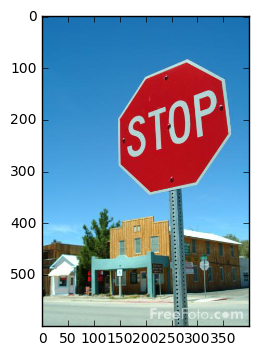

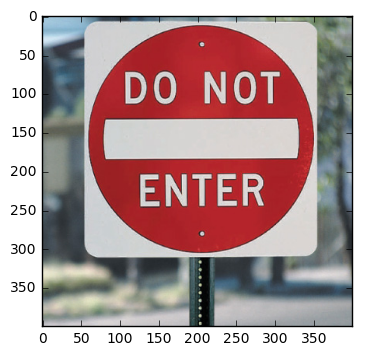

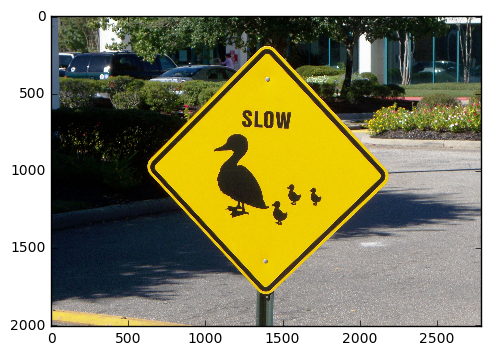

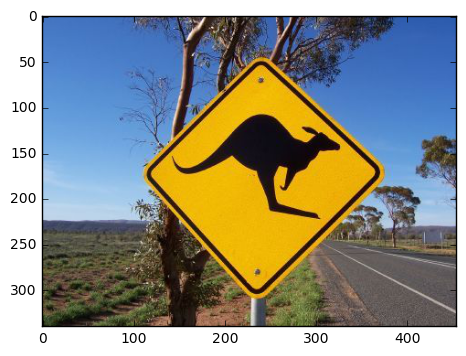

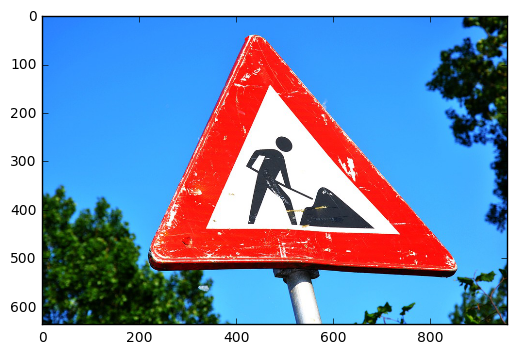

In [21]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

import matplotlib.image as mpimg

imgs = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']

new_input = []

for imgname in imgs:
    image = mpimg.imread('extra-images/' + imgname)
    new_input.append(image)
    plt.imshow(image)
    plt.show()

In [22]:

# Working...
#Test new images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(new_input, )
    print("Test Accuracy = {:.3f}".format(test_accuracy))



ValueError: setting an array element with a sequence.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [23]:

sess.run(tf.nn.top_k(tf.constant(a), k=3))

RuntimeError: Attempted to use a closed Session.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.